In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import joblib
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from torch.amp import autocast, GradScaler
from torch.utils.data import TensorDataset, DataLoader
from torch.nn.utils import clip_grad_norm_
import os
import sys

In [35]:
# Add the parent directory (where utils.py is located) to sys.path to ensure utils module is found
utils_path = os.path.abspath(os.path.join(os.getcwd(), "../../Utils/"))
sys.path.append(utils_path)

from model_utils import ImprovedTagClassifier  # Import our model from utils

In [36]:
# Enable cuDNN benchmarking for faster training
torch.backends.cudnn.benchmark = True

In [37]:
# Load and clean the data
print("Loading and cleaning data...")
df = pd.read_csv("../Dataset/new_figma_dataset11.csv")
if 'parent_tag_html' in df.columns:
    df = df.drop(columns=['parent_tag_html'])
if 'y' in df.columns:
    df = df.drop(columns=['y'])

# Remove rows with weird tags (like '-' or specific unwanted ones)
df = df[~df['tag'].str.contains(r'[-:]', regex=True)]
df = df[~df['tag'].str.contains(r'\b(CNX|ADDRESS|ASIDE|CANVAS|CITE|DD|DL|DT|ICON|S|VECTOR|DEL|LEGEND|BDI|LOGO|OBJECT|OPTGROUP|CENTER|CODE|BLOCKQUOTE|FRONT|Q|IFRAME|A|HR|SEARCH|DETAILS|FIELDSET|SLOT|SVG|AD|ADSLOT|AUDIO|BLINK|BOLD|COL|COLGROUP|COMMENTS|DATA|DIALOG|EMBED|EMPHASIS|FONT|H7|HGROUP|INS|INTERACTION|ITALIC|ITEMTEMPLATE|MARK|MATH|MENU|MI|MN|MO|MROW|MSUP|NOBR|OFFER|OPTION|PATH|PROGRESS|STRIKE|SWAL|TEXT|TFOOT|TITLE|TT|VAR|VEV|W|WBR|COUNTRY|ESI:INCLUDE|HTTPS:|LOGIN|NOCSRIPT|PERSONAL|STONG|CONTENT|DELIVERY|LEFT|MSUBSUP|KBD|ROOT|PARAGRAPH|BE|AI2SVELTEWRAP|BANNER|PHOTO1|UNK)\b', regex=True)]

# Pattern to spot unwanted tags in other columns
pattern = r'[-:]|\b(CNX|ADDRESS|ASIDE|CANVAS|CITE|DD|DL|DT|ICON|S|VECTOR|DEL|LEGEND|BDI|LOGO|OBJECT|OPTGROUP|CENTER|CODE|BLOCKQUOTE|FRONT|Q|IFRAME|SEARCH|DETAILS|FIELDSET|SLOT|AD|ADSLOT|AUDIO|BLINK|BOLD|COL|COLGROUP|COMMENTS|DATA|DIALOG|EMBED|EMPHASIS|FONT|H7|HGROUP|INS|INTERACTION|ITALIC|ITEMTEMPLATE|MARK|MATH|MENU|MI|MN|MO|MROW|MSUP|NOBR|OFFER|OPTION|PATH|PROGRESS|STRIKE|SWAL|TEXT|TFOOT|TITLE|TT|VAR|VEV|W|WBR|COUNTRY|ESI:INCLUDE|HTTPS:|LOGIN|NOCSRIPT|PERSONAL|STONG|CONTENT|DELIVERY|LEFT|MSUBSUP|KBD|ROOT|PARAGRAPH|BE|AI2SVELTEWRAP|BANNER|PHOTO1|UNK)\b'

# Replace unwanted tags with 'DIV' in related columns
for col in ['prev_sibling_html_tag', 'child_1_html_tag', 'child_2_html_tag']:
    df[col] = np.where(df[col].str.contains(pattern, regex=True, na=False), 'DIV', df[col])

# Map tags to simpler ones
tag_mapping = {
    "ARTICLE": "DIV", "DIV": "DIV", "FIGURE": "DIV",
    "HEADER": "DIV", "NAV": "DIV", "MAIN": "DIV",
    "BODY": "DIV", "FORM": "DIV", "OL": "DIV", "UL": "DIV", "TABLE": "DIV", "THEAD": "DIV", "TBODY": "DIV", "SECTION": "DIV",
    "H1": "P", "H2": "P", "H3": "P", "H4": "P", "H5": "P", "H6": "P", "SUP": "P", "SUB": "P", "BIG": "P",
    "P": "P", "CAPTION": "P", "FIGCAPTION": "P", "B": "P", "EM": "P", "I": "P", "TD": "P", "TH": "P", "TR": "P", "PRE": "P",
    "U": "P", "TIME": "P", "TXT": "P", "ABBR": "P", "SMALL": "P", "STRONG": "P", "SUMMARY": "P", "SPAN": "P",
    "PICTURE": "IMG", "VIDEO": "IMG",
    "SELECT": "INPUT", "TEXTAREA": "INPUT",
    "UNK": "DIV", "FOOTER": "DIV", "NAVBAR": "DIV", "LIST": "DIV", "CARD": "DIV",
    "LABEL": "P", "A": "P",
    "DROPDOWN": "INPUT"
}

# Fix specific tags
df.loc[(df["tag"] == "SPAN") & ((df["type"] == "RECTANGLE") | (df["type"] == "GROUP")), "tag"] = "DIV"
children_cols = ['child_1_html_tag', 'child_2_html_tag']
for col in children_cols:
    df[col] = df[col].apply(lambda x: "DIV" if isinstance(x, str) and '-' in x else x)

# Make tags uppercase
df['tag'] = df['tag'].str.upper()
df['prev_sibling_html_tag'] = df['prev_sibling_html_tag'].str.upper()
df['child_1_html_tag'] = df['child_1_html_tag'].str.upper()
df['child_2_html_tag'] = df['child_2_html_tag'].str.upper()

# Apply the tag mapping
df['tag'] = df['tag'].replace(tag_mapping)
df['prev_sibling_html_tag'] = df['prev_sibling_html_tag'].replace(tag_mapping)
df['child_1_html_tag'] = df['child_1_html_tag'].replace(tag_mapping)
df['child_2_html_tag'] = df['child_2_html_tag'].replace(tag_mapping)

# Remove unwanted tags (leave only there effect in feature vector)
df = df[~df['tag'].str.contains(r'\b(P|IMG|SVG|ICON|LI|CHECKBOX|RADIO)\b', regex=True)]

# Show some data info
print("Unique Child 1:", df['child_1_html_tag'].unique())
print("Unique Child 2:", df['child_2_html_tag'].unique())
print("Prev HTML tag:", df['prev_sibling_html_tag'].unique())
print(f"Unique tags after cleaning: {df['tag'].unique()}")
print(f"Total samples: {len(df)}")
print(f"Distribution of tags: \n{df['tag'].value_counts()}")

Loading and cleaning data...


C:\Users\AOZ\AppData\Local\Temp\ipykernel_32272\787916220.py:11: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df = df[~df['tag'].str.contains(r'\b(CNX|ADDRESS|ASIDE|CANVAS|CITE|DD|DL|DT|ICON|S|VECTOR|DEL|LEGEND|BDI|LOGO|OBJECT|OPTGROUP|CENTER|CODE|BLOCKQUOTE|FRONT|Q|IFRAME|A|HR|SEARCH|DETAILS|FIELDSET|SLOT|SVG|AD|ADSLOT|AUDIO|BLINK|BOLD|COL|COLGROUP|COMMENTS|DATA|DIALOG|EMBED|EMPHASIS|FONT|H7|HGROUP|INS|INTERACTION|ITALIC|ITEMTEMPLATE|MARK|MATH|MENU|MI|MN|MO|MROW|MSUP|NOBR|OFFER|OPTION|PATH|PROGRESS|STRIKE|SWAL|TEXT|TFOOT|TITLE|TT|VAR|VEV|W|WBR|COUNTRY|ESI:INCLUDE|HTTPS:|LOGIN|NOCSRIPT|PERSONAL|STONG|CONTENT|DELIVERY|LEFT|MSUBSUP|KBD|ROOT|PARAGRAPH|BE|AI2SVELTEWRAP|BANNER|PHOTO1|UNK)\b', regex=True)]
C:\Users\AOZ\AppData\Local\Temp\ipykernel_32272\787916220.py:18: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  

Unique Child 1: ['DIV' nan 'HR' 'SVG' 'P' 'IMG' 'BUTTON' 'INPUT' 'LI' 'CHECKBOX' 'RADIO']
Unique Child 2: ['DIV' nan 'HR' 'P' 'BUTTON' 'IMG' 'INPUT' 'SVG' 'LI' 'CHECKBOX' 'RADIO']
Prev HTML tag: [nan 'HR' 'BUTTON' 'DIV' 'IMG' 'P' 'INPUT' 'SVG' 'LI' 'CHECKBOX' 'RADIO']
Unique tags after cleaning: ['DIV' 'BUTTON' 'INPUT']
Total samples: 63756
Distribution of tags: 
tag
DIV       60393
BUTTON     2836
INPUT       527
Name: count, dtype: int64


C:\Users\AOZ\AppData\Local\Temp\ipykernel_32272\787916220.py:54: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df = df[~df['tag'].str.contains(r'\b(P|IMG|SVG|ICON|LI|CHECKBOX|RADIO)\b', regex=True)]


In [38]:
# Separate features and target
y = df["tag"]
X = df.drop(columns=["tag"])

In [39]:
# Identify categorical and continuous columns
categorical_cols = ['type','prev_sibling_html_tag','child_1_html_tag','child_2_html_tag']
continuous_cols = [col for col in X.columns if col not in categorical_cols]

In [40]:
# Process categorical features with OneHotEncoder
print("Processing categorical features...")
X[categorical_cols] = X[categorical_cols].astype(str).fillna('unknown')
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_cat_encoded = ohe.fit_transform(X[categorical_cols])
joblib.dump(ohe, "../models/ohe_encoder.pkl")

Processing categorical features...


['../models/ohe_encoder.pkl']

In [41]:
# Handle missing values in continuous features
print("Handling missing values...")
imputer = SimpleImputer(strategy='median')  # Changed to median for better robustness
X_continuous_imputed = imputer.fit_transform(X[continuous_cols])
joblib.dump(imputer, "../models/imputer.pkl")

Handling missing values...


['../models/imputer.pkl']

In [42]:
# Scale continuous features
print("Scaling continuous features...")
scaler = StandardScaler()
X_continuous_scaled = scaler.fit_transform(X_continuous_imputed)
joblib.dump(scaler, "../models/scaler.pkl")

Scaling continuous features...


['../models/scaler.pkl']

In [43]:
# Combine one-hot encoded categorical features with scaled continuous features
X_processed = np.concatenate([X_cat_encoded, X_continuous_scaled], axis=1)

In [44]:
# Encode target labels
print("Encoding target labels...")
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
joblib.dump(label_encoder, "../models/label_encoder.pkl")

Encoding target labels...


['../models/label_encoder.pkl']

In [45]:
# Handle class imbalance by duplicating rare class samples
from collections import Counter
class_counts = Counter(y_encoded)
min_samples_threshold = 10  # Ensure each class has at least this many samples

# Find classes with fewer than min_samples_threshold samples
rare_classes = [cls for cls, count in class_counts.items() if count < min_samples_threshold]

# Duplicate rare class samples to reach the threshold
for cls in rare_classes:
    idx = np.where(y_encoded == cls)[0]  # Get indices of rare samples
    original_class_name = label_encoder.inverse_transform([cls])[0]
    samples_needed = min_samples_threshold - len(idx)
    
    print(f"Augmenting class '{original_class_name}' with {samples_needed} additional samples")
    
    # Create synthetic samples through duplication with slight variations
    for _ in range(samples_needed):
        sample_idx = np.random.choice(idx)  # Choose a random sample from this class
        new_sample = X_processed[sample_idx].copy()
        
        # Add slight noise to continuous features (last part of the feature vector)
        continuous_start = X_cat_encoded.shape[1]
        noise = np.random.normal(0, 0.05, size=X_continuous_scaled.shape[1])
        new_sample[continuous_start:] += noise
        
        X_processed = np.vstack([X_processed, new_sample])
        y_encoded = np.append(y_encoded, cls)

In [46]:
# Split data into train, validation, and test sets
print("Splitting data into train, validation, and test sets...")
X_temp, X_test, y_temp, y_test = train_test_split(
    X_processed, y_encoded, test_size=0.15, random_state=42, stratify=y_encoded
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.15, random_state=42, stratify=y_temp
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Splitting data into train, validation, and test sets...
Training set size: 46063
Validation set size: 8129
Test set size: 9564


In [47]:
# Compute class weights for handling imbalance
print("Computing class weights...")
class_weights = compute_class_weight(
    'balanced', 
    classes=np.unique(y_train), 
    y=y_train
)

for c in np.unique(y_train):
    print(f"Class {label_encoder.inverse_transform([c])[0]}: {class_weights[c]:.4f}")

Computing class weights...
Class BUTTON: 7.4936
Class DIV: 0.3519
Class INPUT: 40.3001


In [48]:
# Convert data to PyTorch tensors
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

Using device: cuda


In [49]:
# Create datasets and dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(
    train_dataset, 
    batch_size=512,
    shuffle=True, 
    num_workers=4,
    pin_memory=True,
    prefetch_factor=2
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=512, 
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=512, 
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

In [50]:
# Initialize model
print("Initializing model...")
input_size = X_train.shape[1]
output_size = len(label_encoder.classes_)
model = ImprovedTagClassifier(input_size, output_size).to(device)

Initializing model...


In [51]:
# Define loss function with focal loss component to handle imbalance
class FocalLoss(nn.Module):
    def __init__(self, weight=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.weight = weight
        self.gamma = gamma
        self.reduction = reduction
        self.ce_loss = nn.CrossEntropyLoss(weight=weight, reduction='none')
        
    def forward(self, inputs, targets):
        ce_loss = self.ce_loss(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# Use a combination of CrossEntropy and Focal Loss
criterion = FocalLoss(weight=class_weights_tensor, gamma=2.0)

# Define optimizer with weight decay and learning rate scheduler
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.5, 
    patience=5, 
    verbose=True
)

C:\Users\AOZ\AppData\Roaming\Python\Python312\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [52]:
# Setup mixed precision training
scaler = GradScaler()

In [53]:
# Define training, validation, and evaluation functions
def train_epoch(model, loader, criterion, optimizer, scaler, device):
    model.train()
    running_loss = 0.0
    
    for batch_X, batch_y in loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        
        with autocast(device_type=device.type):
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
        
        scaler.scale(loss).backward()
        
        # Gradient clipping to prevent exploding gradients
        scaler.unscale_(optimizer)
        clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        scaler.step(optimizer)
        scaler.update()
        
        running_loss += loss.item()
    
    return running_loss / len(loader)

def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch_X, batch_y in loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            with autocast(device_type=device.type):
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
            
            running_loss += loss.item()
            
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    val_loss = running_loss / len(loader)
    
    return val_loss, accuracy, all_preds, all_labels

def evaluate(model, loader, criterion, device, label_encoder):
    val_loss, accuracy, all_preds, all_labels = validate(model, loader, criterion, device)
    
    print(f"\nEvaluation Results:")
    print(f"Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}")
    
    # Display detailed classification report
    print("\nClassification Report:")
    print(classification_report(
        all_labels, 
        all_preds,
        labels=np.unique(all_labels),
        target_names=label_encoder.inverse_transform(np.unique(all_labels)),
        zero_division=0
    ))
    
    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    
    class_names = label_encoder.inverse_transform(np.unique(all_labels))
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    
    # Normalize confusion matrix and print percentages
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, f"{cm[i, j]}\n({cm_norm[i, j]:.2f})",
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig('../models/confusion_matrix.png')
    
    return val_loss, accuracy

In [54]:
# Training loop with early stopping
print("Starting training...")
epochs = 150
best_val_loss = float('inf')
patience = 15
counter = 0
early_stop = False

# For plotting
train_losses = []
val_losses = []
val_accuracies = []

start_time = time.time()

for epoch in range(epochs):
    epoch_start = time.time()
    
    # Train
    train_loss = train_epoch(model, train_loader, criterion, optimizer, scaler, device)
    
    # Validate
    val_loss, val_accuracy, _, _ = validate(model, val_loader, criterion, device)
    
    # Update learning rate based on validation loss
    scheduler.step(val_loss)
    
    # Save metrics for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    # Print progress
    epoch_time = time.time() - epoch_start
    print(f"Epoch [{epoch+1}/{epochs}] - "
          f"Train Loss: {train_loss:.4f}, "
          f"Val Loss: {val_loss:.4f}, "
          f"Val Accuracy: {val_accuracy:.4f}, "
          f"Time: {epoch_time:.2f}s")
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        # Save the best model
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'val_accuracy': val_accuracy
        }, "../models/best_tag_classifier.pth")
        print(f"Model improved and saved!")
    else:
        counter += 1
        print(f"EarlyStopping counter: {counter} out of {patience}")
        if counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            early_stop = True
    
    # Break if early stopping
    if early_stop:
        break

# Total training time
total_time = time.time() - start_time
print(f"Total training time: {total_time:.2f} seconds")

Starting training...
Epoch [1/150] - Train Loss: 5.1298, Val Loss: 1.0124, Val Accuracy: 0.3483, Time: 9.08s
Model improved and saved!
Epoch [2/150] - Train Loss: 3.3927, Val Loss: 0.9300, Val Accuracy: 0.5952, Time: 8.17s
Model improved and saved!
Epoch [3/150] - Train Loss: 2.6863, Val Loss: 0.7138, Val Accuracy: 0.7080, Time: 8.19s
Model improved and saved!
Epoch [4/150] - Train Loss: 2.1876, Val Loss: 0.6052, Val Accuracy: 0.7440, Time: 8.93s
Model improved and saved!
Epoch [5/150] - Train Loss: 2.0017, Val Loss: 0.4712, Val Accuracy: 0.8067, Time: 9.97s
Model improved and saved!
Epoch [6/150] - Train Loss: 1.6685, Val Loss: 0.4064, Val Accuracy: 0.8433, Time: 9.57s
Model improved and saved!
Epoch [7/150] - Train Loss: 1.3883, Val Loss: 0.3541, Val Accuracy: 0.8700, Time: 8.23s
Model improved and saved!
Epoch [8/150] - Train Loss: 1.3147, Val Loss: 0.3478, Val Accuracy: 0.8760, Time: 9.30s
Model improved and saved!
Epoch [9/150] - Train Loss: 1.1375, Val Loss: 0.3139, Val Accuracy:

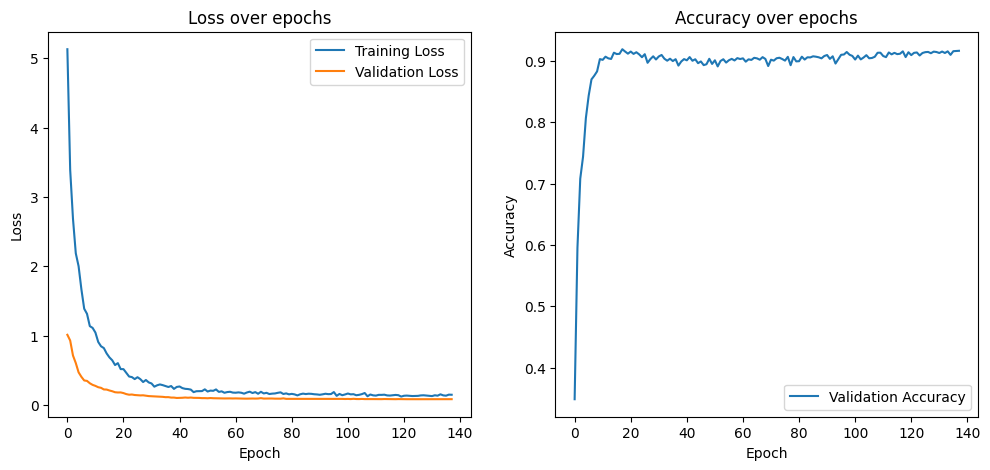

In [55]:
# Plot training history
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.tight_layout()
plt.savefig('../models/training_history.png')
plt.close()

In [56]:
# Load the best model for evaluation
print("Loading best model for evaluation...")
checkpoint = torch.load("../models/best_tag_classifier.pth")
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded model from epoch {checkpoint['epoch']+1} with validation loss: {checkpoint['val_loss']:.4f}")

Loading best model for evaluation...
Loaded model from epoch 123 with validation loss: 0.0836


C:\Users\AOZ\AppData\Local\Temp\ipykernel_32272\2536954669.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("../models/best_tag_classifier.pth")



Evaluating on test set...

Evaluation Results:
Loss: 0.0802, Accuracy: 0.9223

Classification Report:
              precision    recall  f1-score   support

      BUTTON       0.44      0.96      0.60       425
         DIV       1.00      0.92      0.96      9060
       INPUT       0.26      0.99      0.41        79

    accuracy                           0.92      9564
   macro avg       0.57      0.96      0.66      9564
weighted avg       0.97      0.92      0.94      9564


Test Loss: 0.0802
Test Accuracy: 0.9223


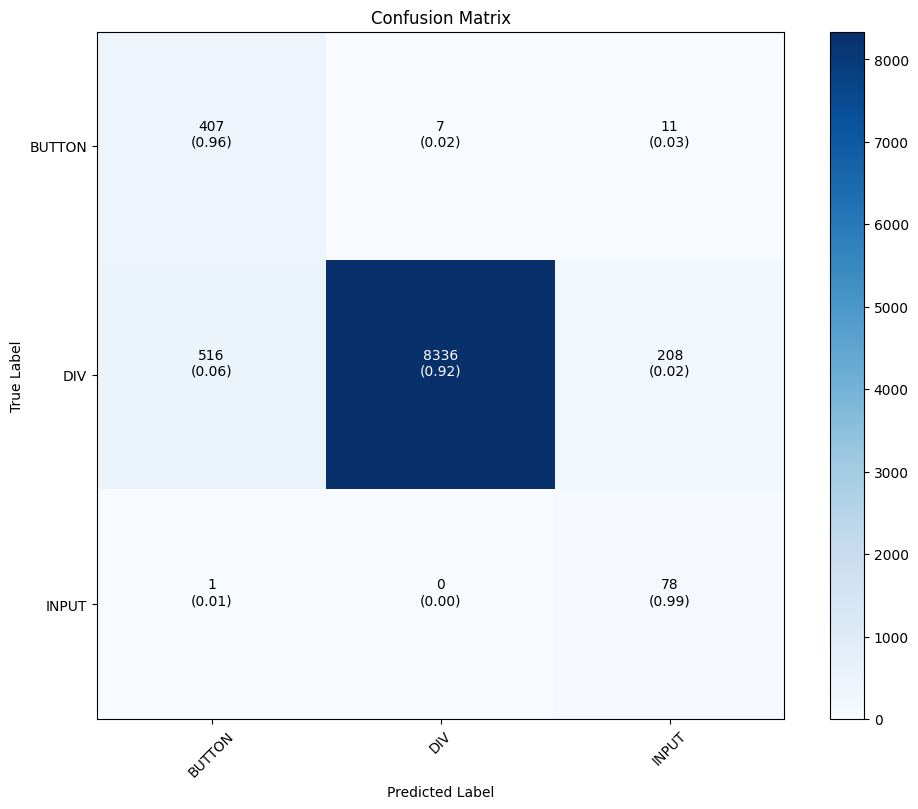

In [57]:
# 23. Evaluate on test set
print("\nEvaluating on test set...")
test_loss, test_accuracy = evaluate(model, test_loader, criterion, device, label_encoder)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

In [58]:
# Feature importance analysis
print("\nAnalyzing feature importance...")
with torch.no_grad():
    # We'll use gradient based feature importance
    # First collect the weights from the first layer
    weights = model.fc1.weight.cpu().numpy()
    importance = np.abs(weights).mean(axis=0)
    
    # Get feature names
    cat_feature_names = ohe.get_feature_names_out(categorical_cols)
    all_feature_names = np.concatenate([cat_feature_names, np.array(continuous_cols)])
    
    # Sort and display
    feature_importance = list(zip(all_feature_names, importance))
    feature_importance.sort(key=lambda x: x[1], reverse=True)
    
    print("\nTop 20 most important features:")
    for i, (feature, imp) in enumerate(feature_importance[:20]):
        print(f"{i+1}. {feature}: {imp:.4f}")
    
    # Visualize top features
    plt.figure(figsize=(12, 6))
    top_features = feature_importance[:15]
    features, importances = zip(*top_features)
    plt.barh(range(len(features)), importances, align='center')
    plt.yticks(range(len(features)), features)
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Top 15 Feature Importances')
    plt.tight_layout()
    plt.savefig('../models/feature_importance.png')
    plt.close()


Analyzing feature importance...

Top 20 most important features:
1. type_VECTOR: 0.0678
2. sibling_count: 0.0641
3. width: 0.0624
4. type_ELLIPSE: 0.0624
5. prev_sibling_html_tag_IMG: 0.0613
6. child_1_html_tag_IMG: 0.0587
7. prev_sibling_html_tag_BUTTON: 0.0579
8. child_2_html_tag_LI: 0.0574
9. nearest_text_node_dist: 0.0571
10. type_GROUP: 0.0560
11. child_1_html_tag_SVG: 0.0552
12. child_2_html_tag_IMG: 0.0548
13. child_1_html_tag_LI: 0.0547
14. type_INSTANCE: 0.0546
15. type_COMPONENT: 0.0543
16. prev_sibling_html_tag_CHECKBOX: 0.0541
17. type_RECTANGLE: 0.0541
18. child_2_html_tag_INPUT: 0.0535
19. child_2_html_tag_SVG: 0.0532
20. child_1_html_tag_BUTTON: 0.0530


In [59]:
# Final model saving
print("\nSaving final model with all preprocessing components...")
torch.save({
    'model_state_dict': model.state_dict(),
    'input_size': input_size,
    'output_size': output_size,
    'scaler': scaler,
    'imputer': imputer,
    'ohe_encoder': ohe,
    'label_encoder': label_encoder
}, "../models/tag_classifier_complete.pth")

print("\nTraining and evaluation complete!")


Saving final model with all preprocessing components...

Training and evaluation complete!
